In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import os
import datetime

#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# sklearn stuff
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Imputer 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

import feature_pipelines as pipes

In [2]:
maindir = "/home/anerdi/Desktop/Zillow"

logerror = pd.read_csv(maindir + "/data/train_2016_v2.csv/train_2016_v2.csv")
logerror['weeknumber'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').isocalendar()[1])
logerror['month'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').month)
properties = pd.read_csv(maindir + "/data/properties_2016.csv/properties_2016.csv")

/home/anerdi/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#proportion of living area
properties['N-LivingAreaProp'] = properties['calculatedfinishedsquarefeet']/properties['lotsizesquarefeet']

#Ratio of the built structure value to land area
properties['N-ValueProp'] = properties['structuretaxvaluedollarcnt']/properties['landtaxvaluedollarcnt']

#Ratio of tax of property over parcel
properties['N-ValueRatio'] = properties['taxvaluedollarcnt']/properties['taxamount']

# Pool
properties['Pool'] = (properties['pooltypeid2'].fillna(0) + properties['pooltypeid7'].fillna(0)).astype(int)

# Age
properties['age'] = 2017 - properties['yearbuilt']

In [4]:
# join on parcel id
data = pd.merge(properties,logerror[['parcelid','logerror','month']], on='parcelid')
del logerror

In [5]:
# # outlier detection and removal (outliers identified by Garcia and Qishu)
# outliers = np.loadtxt("exclude_index.csv", dtype=int)
# data = data.iloc[np.setdiff1d(np.arange(data.shape[0]), outliers),:].reset_index(drop=True)

### New response variables - Overestimation, Extreme Overestimation, and Extreme Underestimation

In [5]:
data['overestimation'] = (data['logerror'] >= 0).astype(int)
data['extreme_overestimation'] = (data['logerror'] >= 1.5).astype(int)
data['extreme_underestimation'] = (data['logerror'] <= -1.5).astype(int)

### Feature selection and Feature Processing

In [6]:
# Setup variables considered in the model


# numerical variables
num_atts = ['bathroomcnt','bedroomcnt','buildingqualitytypeid','calculatedbathnbr','finishedfloor1squarefeet',
           'calculatedfinishedsquarefeet','finishedsquarefeet12','finishedsquarefeet13',
           'finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6','fireplacecnt',
           'fullbathcnt','garagecarcnt','garagetotalsqft','latitude','longitude','lotsizesquarefeet',
           'poolcnt','poolsizesum','censustractandblock','roomcnt','threequarterbathnbr','unitcnt',
           'yardbuildingsqft17','yardbuildingsqft26','numberofstories',
            'structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount',
           'N-ValueRatio', 'N-LivingAreaProp', 'N-ValueProp']

# categorical varaibles
cat_atts = ['airconditioningtypeid','architecturalstyletypeid',
           'buildingclasstypeid','heatingorsystemtypeid','pooltypeid10','pooltypeid2',
            'pooltypeid7','propertylandusetypeid','regionidcounty',
           'storytypeid','typeconstructiontypeid','yearbuilt','fireplaceflag',
           'taxdelinquencyflag']

# Dictionary of categorical variables and their default levels
cat_dict = {key:value for key,value in {'airconditioningtypeid':[-1] + list(range(1,14)),
           'architecturalstyletypeid':[-1] + list(range(1,28)),
           'buildingclasstypeid':[-1] + list(range(1,6)),
            'heatingorsystemtypeid':[-1] + list(range(1,26)),
            'pooltypeid10': list(range(-1,2)),
            'pooltypeid2': list(range(-1,2)),
            'pooltypeid7': list(range(-1,2)),
            'Pool': [0,1],
            'propertylandusetypeid': [-1, 31,46,47,246,247,248,260,261,262,263,264,265,266,267,268,269,270,271,
                                     273,274,275,276,279,290,291],
            'regionidcounty': [2061,3101,1286],
            'storytypeid':[-1] + list(range(1,36)),
            'typeconstructiontypeid':[-1] + list(range(1,19)),
            'yearbuilt': [-1] + list(range(1885,2018)),
            'fireplaceflag': [-1] + ['True','False'],
            'taxdelinquencyflag': [-1] + ['Y','N']
           }.items() if key in cat_atts}

In [7]:
# Categorical pipeline
cat_pipeline = Pipeline([
        ('select_and_dummify', pipes.DF_Selector_GetDummies(cat_dict)),
    ])

# Numerical pipeline
num_pipeline = Pipeline([
        ('selector', pipes.DataFrameSelector(num_atts)),
        ('imputer', Imputer()),
        ('scaler', StandardScaler())
    ])

# Full pipeline
feature_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

## Training Classifiers

In [8]:
X=feature_pipeline.fit_transform(data)
y=data.overestimation

#### Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
clf_l1_LR = LogisticRegression(penalty='l1', tol=0.01)
clf_l1_LR.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False)

In [35]:
clf_l1_LR.score(X,y)

0.57479922459152588

In [36]:
clf_l1_LR.predict_proba(X).mean(axis=0)

array([ 0.43949321,  0.56050679])

In [37]:
confusion_matrix(data['overestimation'], clf_l1_LR.predict(X), labels=[0,1])

array([[ 7833, 31834],
       [ 6551, 44057]])

### Plotting 

In [9]:
def plot_conf_matrix(model, data, X,cutoff=0):
    false_postives = np.where((model.predict_proba(X)[:,1] >= 0.50) & (data['logerror'] < cutoff))[0]
    true_postives = np.where((model.predict_proba(X)[:,1] >= 0.50) & (data['logerror'] >= cutoff))[0]
    true_negatives = np.where((model.predict_proba(X)[:,1] < 0.50) & (data['logerror'] < cutoff))[0]
    false_negatives = np.where((model.predict_proba(X)[:,1] < 0.50) & (data['logerror'] >= cutoff))[0]
    
    plt.figure(figsize=(10,10))
    plt.scatter(model.predict_proba(X)[false_postives,1], data.iloc[false_postives,:]['logerror'],color='red', alpha=0.5)
    plt.scatter(model.predict_proba(X)[true_postives,1], data.iloc[true_postives,:]['logerror'],color='blue', alpha=0.5)
    plt.scatter(model.predict_proba(X)[false_negatives,1], data.iloc[false_negatives,:]['logerror'],color='red', alpha=0.5)
    plt.scatter(model.predict_proba(X)[true_negatives,1], data.iloc[true_negatives,:]['logerror'],color='blue',alpha=0.5)
    plt.show()

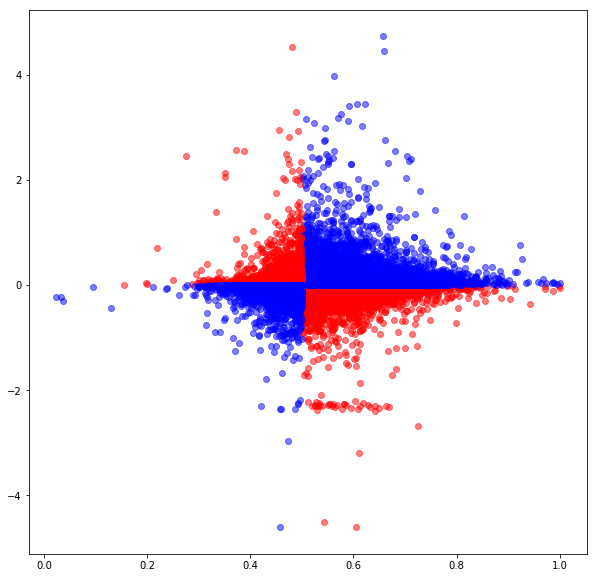

In [39]:
plot_conf_matrix(clf_l1_LR, data, X, cutoff=0)

In [40]:
print(recall_score(data['overestimation'], clf_l1_LR.predict(X)))
print(precision_score(data['overestimation'], clf_l1_LR.predict(X)))
print(f1_score(data['overestimation'], clf_l1_LR.predict(X)))

0.870554062599
0.580529970616
0.696558866078


#### Random Forests 

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
clf_rf_layer1 = RandomForestClassifier(max_depth=12, random_state=9)

In [49]:
clf_rf_layer1.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

In [50]:
clf_rf_layer1.score(X,y)

0.61538631957906398

In [51]:
confusion_matrix(data['overestimation'], clf_rf_layer1.predict(X), labels=[0,1])

array([[ 8707, 30960],
       [ 3761, 46847]])

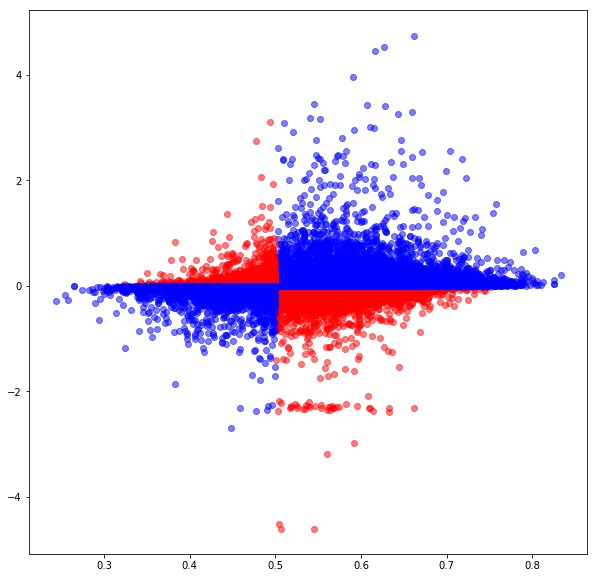

In [52]:
plot_conf_matrix(clf_rf_layer1, data, X, cutoff=0)

In [53]:
print(recall_score(data['overestimation'], clf_rf_layer1.predict(X)))
print(precision_score(data['overestimation'], clf_rf_layer1.predict(X)))
print(f1_score(data['overestimation'], clf_rf_layer1.predict(X)))

0.925683686374
0.602092356729
0.729618814001


#### XGBClassifier

In [54]:
from xgboost import XGBClassifier

In [55]:
clf_xgb_layer1 = XGBClassifier(max_depth=7, random_state=9, n_jobs=2)

In [56]:
clf_xgb_layer1.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=2, nthread=None, objective='binary:logistic', random_state=9,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [57]:
clf_xgb_layer1.score(X,y)

0.64775408474106899

In [58]:
confusion_matrix(data['overestimation'], clf_xgb_layer1.predict(X), labels=[0,1])

array([[13257, 26410],
       [ 5389, 45219]])

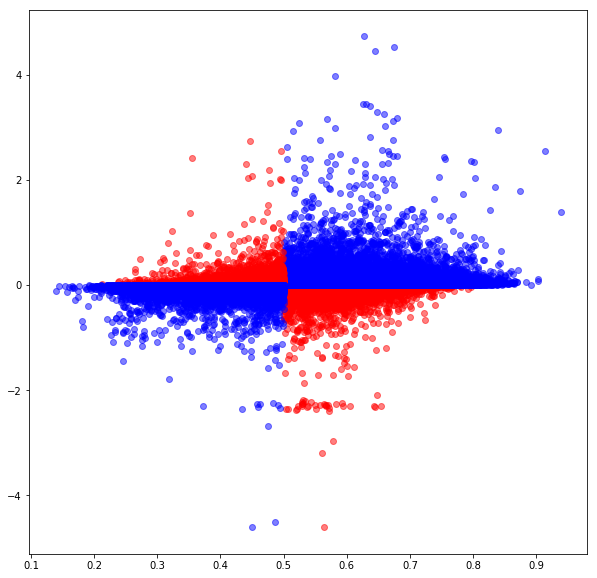

In [59]:
plot_conf_matrix(clf_xgb_layer1, data, X, cutoff=0)

In [60]:
print(recall_score(data['overestimation'], clf_xgb_layer1.predict(X)))
print(precision_score(data['overestimation'], clf_xgb_layer1.predict(X)))
print(f1_score(data['overestimation'], clf_xgb_layer1.predict(X)))

0.893514859311
0.631294587388
0.739857817191


#### LightGBM Classifier

In [10]:
from lightgbm import LGBMClassifier

In [68]:
clf_lightgbm_layer1 = LGBMClassifier(random_state=9, n_jobs=2, n_estimators=100, boosting_type="gbdt")

In [69]:
clf_lightgbm_layer1.fit(X,y)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0.0, n_estimators=100, n_jobs=2,
        num_leaves=31, objective=None, random_state=9, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=50000, subsample_freq=1)

In [70]:
clf_lightgbm_layer1.score(X,y)

0.6212572694544447

In [71]:
confusion_matrix(data['overestimation'], clf_lightgbm_layer1.predict(X), labels=[0,1])

array([[11546, 28121],
       [ 6070, 44538]])

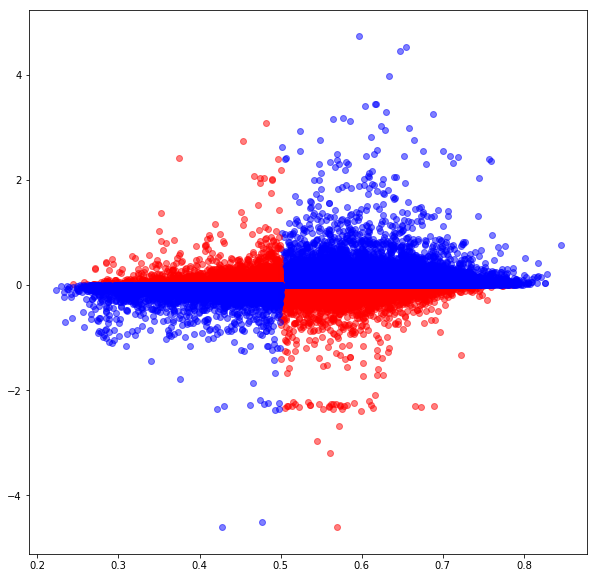

In [72]:
plot_conf_matrix(clf_lightgbm_layer1, data, X, cutoff=0)

In [73]:
print(recall_score(data['overestimation'], clf_lightgbm_layer1.predict(X)))
print(precision_score(data['overestimation'], clf_lightgbm_layer1.predict(X)))
print(f1_score(data['overestimation'], clf_lightgbm_layer1.predict(X)))

0.880058488776
0.612972928336
0.722626493709


## Second Layer of Classification

### Extreme Overestimation

In [37]:
X_over = feature_pipeline.fit_transform(data[data['overestimation'] == 1])
y_extreme_over = data[data['overestimation'] == 1]['extreme_overestimation']

In [38]:
assert X_over.shape[0] == y_extreme_over.shape[0]

In [62]:
clf_rf_layer2_over = RandomForestClassifier(max_depth=12, random_state=9, class_weight='balanced')

In [63]:
clf_rf_layer2_over.fit(X_over, y_extreme_over)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=9,
            verbose=0, warm_start=False)

In [64]:
confusion_matrix(data[data['overestimation'] == 1]['extreme_overestimation'], clf_rf_layer2_over.predict(X_over), labels=[0,1])

array([[50309,   197],
       [   31,    71]])

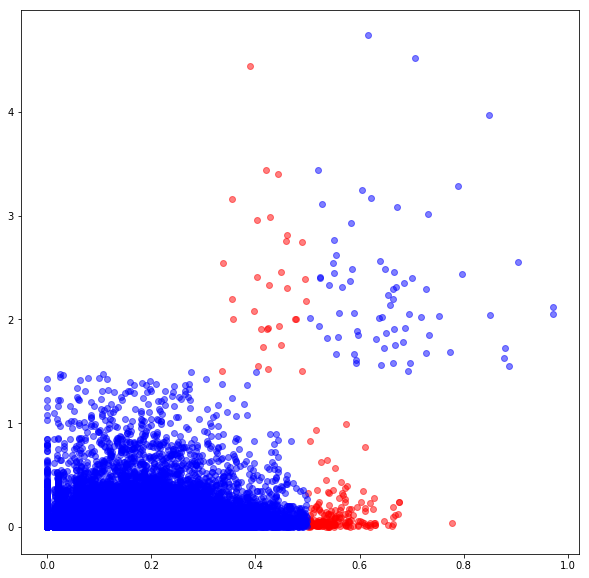

In [65]:
plot_conf_matrix(clf_rf_layer2_over, data[data['overestimation'] == 1], X_over, cutoff=1.5)

### Extreme UnderEstimation

In [49]:
X_under = feature_pipeline.fit_transform(data[data['overestimation'] == 0])
y_extreme_under = data[data['overestimation'] == 0]['extreme_underestimation']

In [50]:
assert X_under.shape[0] == y_extreme_under.shape[0]

In [66]:
clf_rf_layer2_under = RandomForestClassifier(max_depth=12, random_state=9, class_weight='balanced')

In [67]:
clf_rf_layer2_under.fit(X_under, y_extreme_under)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=9,
            verbose=0, warm_start=False)

In [68]:
confusion_matrix(data[data['overestimation'] == 0]['extreme_underestimation'], clf_rf_layer2_under.predict(X_under), labels=[0,1])

array([[39520,    88],
       [   17,    42]])

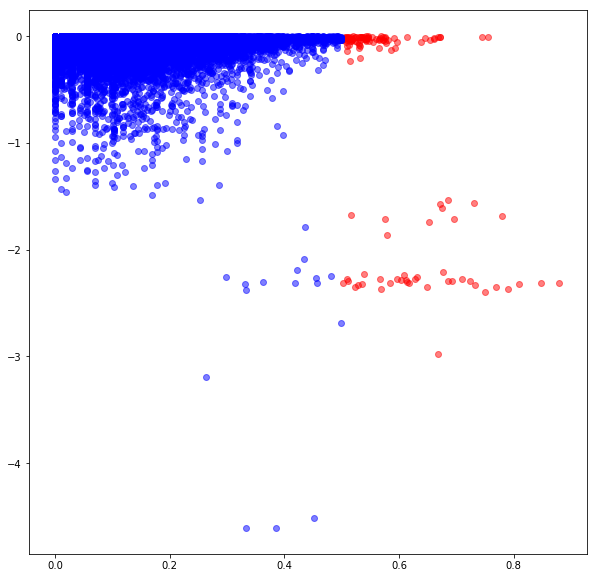

In [69]:
plot_conf_matrix(clf_rf_layer2_under, data[data['overestimation'] == 0], X_under, cutoff=1.5)

## Combining 1st and 2nd Layers of Classifiers

In [55]:
# objective here is to obtain, for each obs, the following probabilities:
# 1. P(overestimation & not_extreme_overestimation)
# 2. P(overestimation & extreme_overestimation)
# 3. P(underestimation & not_extreme_underestimation)
# 4. P(underestimation & extreme_underestimation)

# layer1: Classifiers to determine P(overestimation)
# layer2: Two classifiers to determine P(extreme_overestimation | overestimation) and
#     P(extreme_underestmation | underestimation)

In [73]:
layer1_probs = clf_rf_layer1.predict_proba(X)

In [77]:
layer2_over_probs = clf_rf_layer2_over.predict_proba(X)
layer2_under_probs = clf_rf_layer2_under.predict_proba(X)

In [86]:
overestimation_probs = layer1_probs[:,1][:,np.newaxis]*layer2_over_probs
underestimation_probs = layer1_probs[:,0][:,np.newaxis]*layer2_under_probs

In [92]:
overall_probs = np.concatenate((underestimation_probs,overestimation_probs), axis=1)

In [102]:
overall_probs

array([[ 0.29736287,  0.02771856,  0.61296234,  0.06195623],
       [ 0.46090236,  0.01370793,  0.42203374,  0.10335597],
       [ 0.3913522 ,  0.02392157,  0.58472624,  0.        ],
       ..., 
       [ 0.34790984,  0.07798328,  0.42209953,  0.15200736],
       [ 0.40363704,  0.0599062 ,  0.53645675,  0.        ],
       [ 0.2844999 ,  0.10192423,  0.51758824,  0.09598763]])

In [101]:
overall_probs.sum(axis=1).sum()

90275.0

In [103]:
overall_probs.mean(axis=0)

array([ 0.38467161,  0.05412059,  0.4755981 ,  0.0856097 ])

### Predict on properties data frame

In [44]:
model = clf_rf
probabilities = None
for i in range(int(properties.shape[0] / 100000)):   
    # get current test features
    current_test_feats = feature_pipeline.transform(properties.iloc[i*100000:(i+1)*100000])
    
    # predict on current test obs
    current_probs = Series(model.predict_proba(current_test_feats)[:,1], name='overestimate_prob',
                          index = np.arange(i*100000,(i+1)*100000))
    
    if probabilities is not None:
        probabilities = pd.concat([probabilities, current_probs])
    else:
        probabilities = current_probs

#  fencepost problem
current_test_feats = feature_pipeline.transform(properties.iloc[2900000:])
current_probs = Series(model.predict_proba(current_test_feats)[:,1], name='overestimate_prob',
                      index = np.arange(2900000,2985217))
probabilities = pd.concat([probabilities, current_probs])

In [45]:
del properties
import gc
gc.collect()

10684

In [46]:
overestimate_probs = pd.read_csv(maindir + "/data/properties_2016.csv/properties_2016.csv", usecols=['parcelid'])
overestimate_probs = pd.concat([overestimate_probs, probabilities], axis=1)
overestimate_probs.head()

,parcelid,overestimate_prob
0,10754147,0.495383
1,10759547,0.524675
2,10843547,0.548752
3,10859147,0.543329
4,10879947,0.485341


In [47]:
overestimate_probs.shape

(2985217, 2)

In [48]:
overestimate_probs.to_csv("/home/anerdi/Desktop/Zillow/twostagemodel/overestimate_probs_rf_5545.csv.gz", 
                          index=False, compression="gzip")